In [2]:
%pylab inline
%matplotlib inline

# Global Imports
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
from sklearn import datasets
import os
import sys
import pickle
from pprint import pprint
from time import time
import datetime
from time import gmtime, strftime
import statsmodels.api as sm
from patsy import dmatrices

# Scikit-Learn imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import cross_val_score
from sklearn import metrics

# Local Imports
path = str(os.path.expanduser('~')) + '/git/predictEPL/config'
sys.path.append(path)
import paths

sys.path.append(paths.UTILS)
import useful_methods

Populating the interactive namespace from numpy and matplotlib


## Data Manipulation Functions

In [9]:
def ReadEmolexDf():
    # Read game_infos as df
    dfGameInfo = useful_methods.csv_dic_df(paths.READ_PATH_GAME_INFO + 'game_infos.csv')
    dfGameInfo = useful_methods.DropNanGames(dfGameInfo).copy().reset_index(drop=True)
    dfGameInfo.GW = [int(gw) for gw in dfGameInfo.GW]
    dfGameInfo = dfGameInfo.sort_values(['GW', 'away_team'], ascending=[True, True]).copy().reset_index(drop=True)

    # Read Hash Emolex Model result
    df = useful_methods.csv_dic_df(paths.READ_PATH_RESULTS + RESULT_FILE_NAME)
    df.GW = [int(gw) for gw in df.GW]
    df = df.sort_values(['GW', 'away_team'], ascending=[True, True]).copy().reset_index(drop=True)

    df.emolex_home = [np.array([float(emo.strip()) for emo in emolex_home[1:-2].split('.')]) for emolex_home in list(df.emolex_home)]
    df.emolex_away = [np.array([float(emo.strip()) for emo in emolex_away[1:-2].split('.')]) for emolex_away in list(df.emolex_away)]


    # Combine 2 dfs
    df['score_ht_away'] = [int(item) for item in dfGameInfo.score_ht_away]
    df['score_ht_home'] = [int(item) for item in dfGameInfo.score_ht_home]
    df['score_ft_away'] = [int(item) for item in dfGameInfo.score_ft_away]
    df['score_ft_home'] = [int(item) for item in dfGameInfo.score_ft_home]

    # 'home_win': 1, 'away_win': 0, 'draw': 2
    def Labeling(goal_diff):
        if goal_diff > 0:
            return 1
        elif goal_diff < 0:
            return 0
        else:
            return 2

    df['goal_diff_ht'] = df.score_ht_home - df.score_ht_away
    df['goal_diff_ft'] = df.score_ft_home - df.score_ft_away
    df['result'] = [Labeling(item) for item in df.goal_diff_ft]


    # **********************************************
    # Add previous 4 games points sum
    dfBe4GameSum = useful_methods.csv_dic_df(paths.DATA_HOME + "EPL/info_before_4game_sum.csv")

    team_homes = list(df.home_team)
    team_aways = list(df.away_team)
    GWs = [int(gw) for gw in df.GW]

    be_4game_sum_home = []
    be_4game_sum_away = []

    for index in range(len(GWs)):
        team_home = team_homes[index]
        team_away = team_aways[index]
        gw = GWs[index]

        be_4game_sum_home.append(int(dfBe4GameSum[dfBe4GameSum.team == team_home][str(gw)]))
        be_4game_sum_away.append(int(dfBe4GameSum[dfBe4GameSum.team == team_away][str(gw)]))

    df['be_4game_sum_away'] = be_4game_sum_away
    df['be_4game_sum_home'] = be_4game_sum_home    

    return df

In [24]:
# Create df for models.
def CreateDfForModel(ht_draw=False, ft_wld=False):
    df = ReadEmolexDf()
        
    # only for Win or Lose
    if not ft_wld:
        df = df[df.result != 2].copy().reset_index(drop=True)
    
    # HT: Equal
    if ht_draw:
        df = df[df.goal_diff_ht == 0].copy().reset_index(drop=True)
    
    dta = pd.DataFrame()
    
    # Teams
    dta['team_home'] = df.home_team
    dta['team_away'] = df.away_team
    
    # HF scores
    dta['score_ht_home'] = df.score_ht_home
    dta['score_ht_away'] = df.score_ht_away
    
    dta['goal_diff_ht'] = df['goal_diff_ht']
    dta['goal_diff_ft'] = df['goal_diff_ft']

    # 'home_win': 1, 'away_win': 0, 'draw': 2
    dta['result'] = df.result
    
    # be_4game_sum
    dta['be_4game_sum_home'] = df.be_4game_sum_home / 12.0
    dta['be_4game_sum_away'] = df.be_4game_sum_away / 12.0
    
    # Emolex 8
    dta['anger_home'] = [emolex[0] / sum(emolex[:-2]) for emolex in df.emolex_home]
    dta['fear_home'] = [emolex[1] / sum(emolex[:-2]) for emolex in df.emolex_home]
    dta['disgust_home'] = [emolex[2] / sum(emolex[:-2]) for emolex in df.emolex_home]
    dta['sadness_home'] = [emolex[3] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['surprise_home'] = [emolex[4] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['trust_home'] = [emolex[5] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['joy_home'] = [emolex[6] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['anticipation_home'] = [emolex[7] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['pos_home'] = [emolex[8] / sum(emolex[-2:])  for emolex in df.emolex_home]
    dta['neg_home'] = [emolex[9] / sum(emolex[-2:])  for emolex in df.emolex_home]

    dta['anger_away'] = [emolex[0] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['fear_away'] = [emolex[1] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['disgust_away'] = [emolex[2] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['sadness_away'] = [emolex[3] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['surprise_away'] = [emolex[4] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['trust_away'] = [emolex[5] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['joy_away'] = [emolex[6] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['anticipation_away'] = [emolex[7] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['pos_away'] = [emolex[8] / sum(emolex[-2:])  for emolex in df.emolex_away]
    dta['neg_away'] = [emolex[9] / sum(emolex[-2:])  for emolex in df.emolex_away]
    
    
    # Diffs
    dta['diff_anger'] = dta['anger_home'] - dta['anger_away']
    dta['diff_fear'] = dta['fear_home'] - dta['fear_away']
    dta['diff_disgust'] = dta['disgust_home'] - dta['disgust_away']
    dta['diff_sadness'] = dta['sadness_home'] - dta['sadness_away']
    dta['diff_surprise'] = dta['surprise_home'] - dta['surprise_away']
    dta['diff_trust'] = dta['trust_home'] - dta['trust_away']
    dta['diff_joy'] = dta['joy_home'] - dta['joy_away']
    dta['diff_anticipation'] = dta['anticipation_home'] - dta['anticipation_away']
    dta['diff_pos'] = dta['pos_home'] - dta['pos_away']
    dta['diff_neg'] = dta['neg_home'] - dta['neg_away']
    
    
    return dta

In [5]:
# X: df, y: list
def CreateXy(df, team_name=False, emolex=True, score_ht=True, be_4game_sum=False):
    if team_name and emolex and score_ht and be_4game_sum:
        y, X = dmatrices('result ~ \
            be_4game_sum_home + be_4game_sum_away + \
            score_ht_home + score_ht_away + \
            anger_home + fear_home + disgust_home + sadness_home + \
            surprise_home + trust_home + joy_home + anticipation_home + \
            anger_away + fear_away + disgust_away + sadness_away + \
            surprise_away + trust_away + joy_away + anticipation_away + \
            pos_home + neg_home + pos_away + neg_away + \
            C(team_home) + C(team_away)',
            df, return_type="dataframe")
    elif emolex and score_ht and be_4game_sum:
        y, X = dmatrices('result ~ \
            be_4game_sum_home + be_4game_sum_away + \
            score_ht_home + score_ht_away + \
            anger_home + fear_home + disgust_home + sadness_home + \
            surprise_home + trust_home + joy_home + anticipation_home + \
            anger_away + fear_away + disgust_away + sadness_away + \
            surprise_away + trust_away + joy_away + anticipation_away + \
            pos_home + neg_home + pos_away + neg_away',
            df, return_type="dataframe")
    elif emolex and be_4game_sum:
        y, X = dmatrices('result ~ \
            be_4game_sum_home + be_4game_sum_away + \
            anger_home + fear_home + disgust_home + sadness_home + \
            surprise_home + trust_home + joy_home + anticipation_home + \
            anger_away + fear_away + disgust_away + sadness_away + \
            surprise_away + trust_away + joy_away + anticipation_away + \
            pos_home + neg_home + pos_away + neg_away',
            df, return_type="dataframe")
    elif score_ht and be_4game_sum:
        y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away + \
            be_4game_sum_home + be_4game_sum_away',
            df, return_type="dataframe")
    elif emolex:
        y, X = dmatrices('result ~ \
            anger_home + fear_home + disgust_home + sadness_home + \
            surprise_home + trust_home + joy_home + anticipation_home + \
            anger_away + fear_away + disgust_away + sadness_away + \
            surprise_away + trust_away + joy_away + anticipation_away + \
            pos_home + neg_home + pos_away + neg_away',
            df, return_type="dataframe")
    else:
        y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away',
            df, return_type="dataframe")
        
    # flatten y into a 1-D array
    y = np.ravel(y)
    
    return X, y

## Models: Logistic, SVC

In [6]:
def ModelScoresWL(df, team_name, emolex, score_ht, be_4game_sum, variable_scores=False):
    # instantiate a logistic regression model, and fit with X and y
    X, y = CreateXy(df, team_name, emolex, score_ht, be_4game_sum)

    # Set Models
    model_log = LogisticRegression()
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(SVC(), X, y, scoring='accuracy', cv=18)

    # Accuracy scores
    print("--------------------------\n")
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))
    
    
    if variable_scores:
        # Variable Scores
        dfVars = pd.DataFrame()
        dfVars['var'] = X.columns
        dfVars['score'] = np.transpose(model_log.coef_)
        print("\n", dfVars)

In [7]:
def ModelScoresWLD(df, team_name, emolex, score_ht, be_4game_sum):
    # instantiate a logistic regression model, and fit with X and y
    X, y = CreateXy(df, team_name, emolex, score_ht, be_4game_sum)

    # Set Models
    model_log = LogisticRegression()
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(SVC(), X, y, scoring='accuracy', cv=18)

    # Accuracy scores
    print("--------------------------\n")
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))

### Accuracy

In [8]:
# Definings
RESULT_FILE_NAME = "emolex_all_ht.csv"

In [11]:
# Create DFs for models
# WL: win, lose; WLD: win, lose, draw
dfWL = CreateDfForModel(ht_draw=False, ft_wld=False)
dfWLD = CreateDfForModel(ht_draw=False, ft_wld=True)

In [12]:
# Win, Lose
ModelScoresWL(dfWL, team_name=False, emolex=False, score_ht=True, be_4game_sum=False, variable_scores=False)
ModelScoresWL(dfWL, team_name=False, emolex=False, score_ht=True, be_4game_sum=True, variable_scores=False)
ModelScoresWL(dfWL, team_name=False, emolex=True, score_ht=False, be_4game_sum=False, variable_scores=False)
ModelScoresWL(dfWL, team_name=False, emolex=True, score_ht=False, be_4game_sum=True, variable_scores=False)
ModelScoresWL(dfWL, team_name=False, emolex=True, score_ht=True, be_4game_sum=True, variable_scores=False)
ModelScoresWL(dfWL, team_name=True, emolex=True, score_ht=True, be_4game_sum=True, variable_scores=False)

--------------------------

[Log]: 	0.766 (cv: 0.765)
[SVC]: 	0.766 (cv: 0.765)
--------------------------

[Log]: 	0.781 (cv: 0.743)
[SVC]: 	0.766 (cv: 0.765)
--------------------------

[Log]: 	0.695 (cv: 0.665)
[SVC]: 	0.594 (cv: 0.594)
--------------------------

[Log]: 	0.719 (cv: 0.710)
[SVC]: 	0.594 (cv: 0.594)
--------------------------

[Log]: 	0.773 (cv: 0.742)
[SVC]: 	0.750 (cv: 0.733)
--------------------------

[Log]: 	0.859 (cv: 0.711)
[SVC]: 	0.758 (cv: 0.742)


In [13]:
ModelScoresWLD(dfWLD, team_name=False, emolex=False, score_ht=True, be_4game_sum=False)
ModelScoresWLD(dfWLD, team_name=False, emolex=False, score_ht=True, be_4game_sum=True)
ModelScoresWLD(dfWLD, team_name=False, emolex=True, score_ht=False, be_4game_sum=False)
ModelScoresWLD(dfWLD, team_name=False, emolex=True, score_ht=False, be_4game_sum=True)
ModelScoresWLD(dfWLD, team_name=False, emolex=True, score_ht=True, be_4game_sum=True)
ModelScoresWLD(dfWLD, team_name=True, emolex=True, score_ht=True, be_4game_sum=True)

--------------------------

[Log]: 	0.554 (cv: 0.553)
[SVC]: 	0.582 (cv: 0.493)
--------------------------

[Log]: 	0.588 (cv: 0.541)
[SVC]: 	0.599 (cv: 0.498)
--------------------------

[Log]: 	0.514 (cv: 0.503)
[SVC]: 	0.429 (cv: 0.431)
--------------------------

[Log]: 	0.520 (cv: 0.498)
[SVC]: 	0.429 (cv: 0.431)
--------------------------

[Log]: 	0.599 (cv: 0.535)
[SVC]: 	0.542 (cv: 0.530)
--------------------------

[Log]: 	0.678 (cv: 0.524)
[SVC]: 	0.548 (cv: 0.537)


## Variable Tune

In [18]:
def ModelAccuracy(X, y, penalty='l2'):
    # Set Models
    model_log = LogisticRegression(penalty=penalty)
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(model_log, X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(model_svc, X, y, scoring='accuracy', cv=18)

    # Accuracy scores
    print("--------------------------\n")
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))


    # Variable Scores
    dfVars = pd.DataFrame()
    dfVars['var'] = X.columns
    dfVars['score'] = np.transpose(model_log.coef_)
    print("\n", dfVars)

In [27]:
df.columns

Index(['team_home', 'team_away', 'score_ht_home', 'score_ht_away',
       'goal_diff_ht', 'goal_diff_ft', 'result', 'be_4game_sum_home',
       'be_4game_sum_away', 'anger_home', 'fear_home', 'disgust_home',
       'sadness_home', 'surprise_home', 'trust_home', 'joy_home',
       'anticipation_home', 'pos_home', 'neg_home', 'anger_away', 'fear_away',
       'disgust_away', 'sadness_away', 'surprise_away', 'trust_away',
       'joy_away', 'anticipation_away', 'pos_away', 'neg_away', 'diff_anger',
       'diff_fear', 'diff_disgust', 'diff_sadness', 'diff_surprise',
       'diff_trust', 'diff_joy', 'diff_anticipation', 'diff_pos', 'diff_neg'],
      dtype='object')

In [41]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
    'result ~ \
    score_ht_home + score_ht_away + goal_diff_ht',
    df, return_type="dataframe")

y = np.ravel(y)

ModelAccuracy(X, y, penalty='l2')

--------------------------

[Log]: 	0.766 (cv: 0.765)
[SVC]: 	0.766 (cv: 0.765)

              var     score
0      Intercept  0.101623
1  score_ht_home  0.326241
2  score_ht_away -0.832713
3   goal_diff_ht  1.158954


In [43]:
# Definings
RESULT_FILE_NAME = "emolex_all_ht.csv"

df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
    'result ~ \
    anger_home + fear_home + disgust_home + sadness_home + \
    surprise_home + trust_home + joy_home + anticipation_home + \
    anger_away + fear_away + disgust_away + sadness_away + \
    surprise_away + trust_away + joy_away + anticipation_away + \
    pos_home + neg_home + pos_away + neg_away + \
    diff_anger + diff_fear + diff_disgust + diff_sadness + diff_surprise + \
    diff_trust + diff_joy + diff_anticipation + diff_pos + diff_neg',
    df, return_type="dataframe")

y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.750 (cv: 0.750)
[SVC]: 	0.594 (cv: 0.594)

                   var     score
0           Intercept  0.000000
1          anger_home  0.000000
2           fear_home  0.000000
3        disgust_home  0.000000
4        sadness_home  0.000000
5       surprise_home  0.000000
6          trust_home  0.000000
7            joy_home  0.000000
8   anticipation_home  0.000000
9          anger_away  0.000000
10          fear_away  0.000000
11       disgust_away  0.000000
12       sadness_away  0.000000
13      surprise_away  0.000000
14         trust_away  0.000000
15           joy_away  0.000000
16  anticipation_away  0.000000
17           pos_home  0.405314
18           neg_home  0.000000
19           pos_away  0.000000
20           neg_away  0.000000
21         diff_anger  0.000000
22          diff_fear  0.000000
23       diff_disgust  0.000000
24       diff_sadness  0.000000
25      diff_surprise  0.000000
26         diff_trust  0.000000
27           diff_joy 

In [46]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
    'result ~ \
    pos_home + neg_home + pos_away + neg_away + \
    diff_pos + diff_neg',
    df, return_type="dataframe")

y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.750 (cv: 0.750)
[SVC]: 	0.672 (cv: 0.640)

          var     score
0  Intercept  0.000000
1   pos_home  0.405363
2   neg_home  0.000000
3   pos_away  0.000000
4   neg_away  0.000000
5   diff_pos  0.086396
6   diff_neg -4.317170


In [49]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
    'result ~ \
    anger_home + fear_home + disgust_home + sadness_home + \
    surprise_home + trust_home + joy_home + anticipation_home + \
    anger_away + fear_away + disgust_away + sadness_away + \
    surprise_away + trust_away + joy_away + anticipation_away + \
    diff_anger + diff_fear + diff_disgust + diff_sadness + diff_surprise + \
    diff_trust + diff_joy + diff_anticipation',
    df, return_type="dataframe")

y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.703 (cv: 0.674)
[SVC]: 	0.594 (cv: 0.594)

                   var     score
0           Intercept  0.033178
1          anger_home  0.000000
2           fear_home  0.000000
3        disgust_home  0.000000
4        sadness_home  0.000000
5       surprise_home  0.000000
6          trust_home  0.000000
7            joy_home  0.000000
8   anticipation_home  0.000000
9          anger_away  0.000000
10          fear_away  0.000000
11       disgust_away  0.000000
12       sadness_away  0.000000
13      surprise_away  0.000000
14         trust_away  0.000000
15           joy_away  0.000000
16  anticipation_away  0.000000
17         diff_anger  0.000000
18          diff_fear  0.000000
19       diff_disgust  0.000000
20       diff_sadness  0.000000
21      diff_surprise  0.000000
22         diff_trust  0.950901
23           diff_joy  4.688225
24  diff_anticipation  0.000000


## Scatter Matrix Plot

In [51]:
df.columns

Index(['team_home', 'team_away', 'score_ht_home', 'score_ht_away',
       'goal_diff_ht', 'goal_diff_ft', 'result', 'be_4game_sum_home',
       'be_4game_sum_away', 'anger_home', 'fear_home', 'disgust_home',
       'sadness_home', 'surprise_home', 'trust_home', 'joy_home',
       'anticipation_home', 'pos_home', 'neg_home', 'anger_away', 'fear_away',
       'disgust_away', 'sadness_away', 'surprise_away', 'trust_away',
       'joy_away', 'anticipation_away', 'pos_away', 'neg_away', 'diff_anger',
       'diff_fear', 'diff_disgust', 'diff_sadness', 'diff_surprise',
       'diff_trust', 'diff_joy', 'diff_anticipation', 'diff_pos', 'diff_neg'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a3ddcf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10bba9e48>]], dtype=object)

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


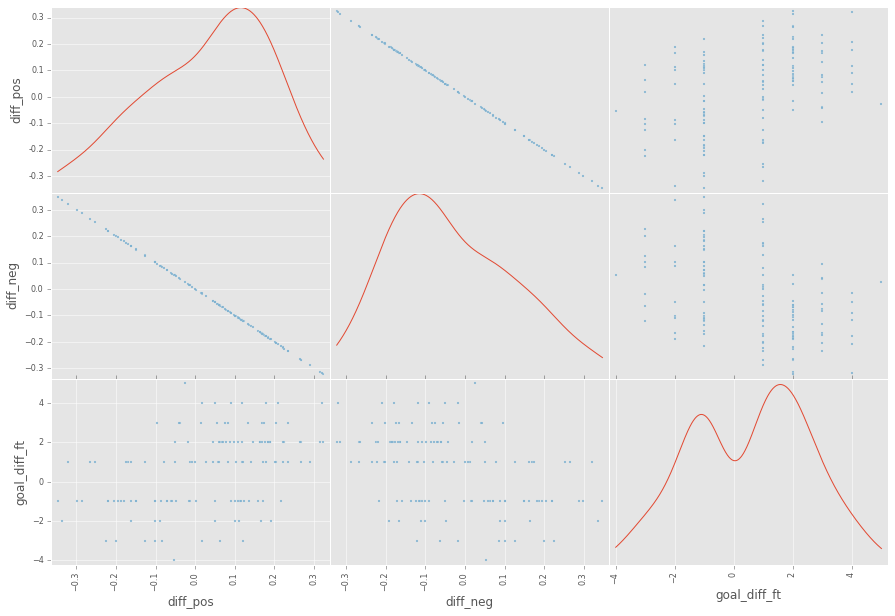

In [55]:
from pandas.tools.plotting import scatter_matrix

df = CreateDfForModel(ft_wld=False)
dta = df[[
        'diff_pos', 'diff_neg',
        'goal_diff_ft']]

scatter_matrix(dta, alpha=0.8, figsize=(15, 10), diagonal='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bc7aba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d42a3c8>]], dtype=object)

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


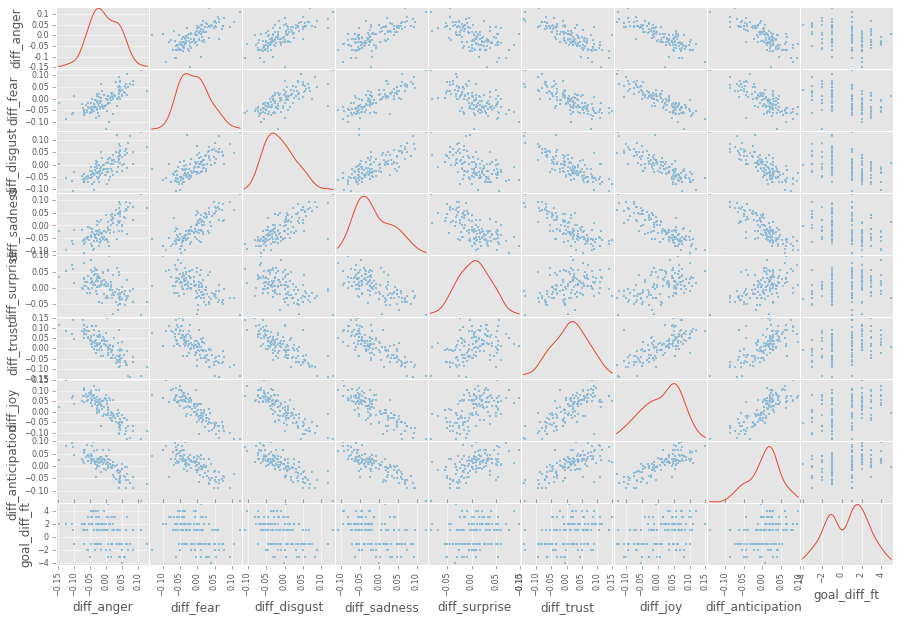

In [56]:
dta = df[[
        'diff_anger', 'diff_fear', 'diff_disgust', 'diff_sadness', 'diff_surprise',
        'diff_trust', 'diff_joy', 'diff_anticipation', 
        'goal_diff_ft']]

scatter_matrix(dta, alpha=0.8, figsize=(15, 10), diagonal='kde')

## Andrew Curve

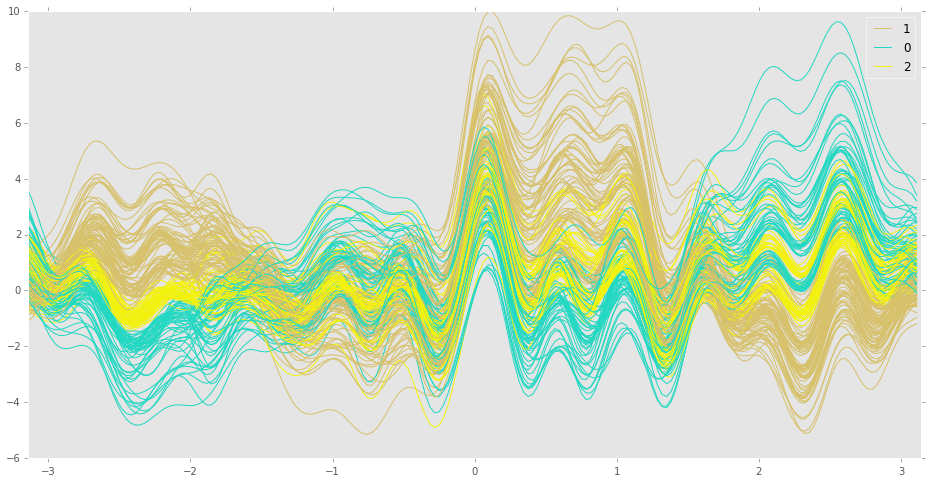

In [62]:
from pandas.tools.plotting import andrews_curves

df = CreateDfForModel(ft_wld=True)
# data = df[['pn_diff_pos'] + ['result']]
data = df[df.columns[2:]]

plt.figure(figsize=(16, 8))
andrews_curves(data, 'result')

## Parallel Coordinates

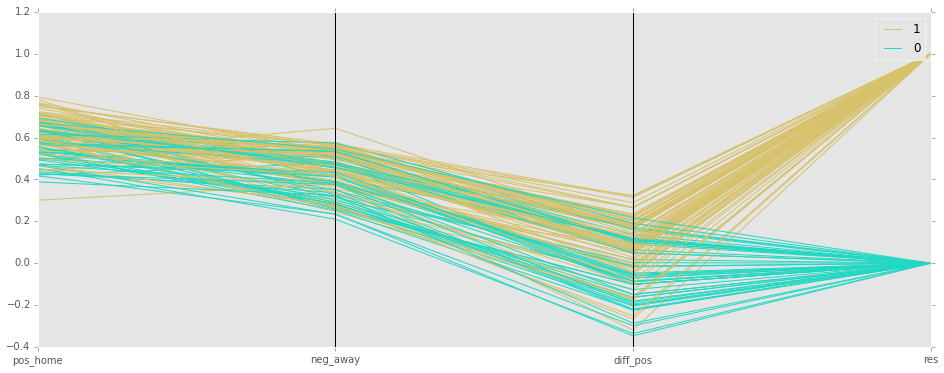

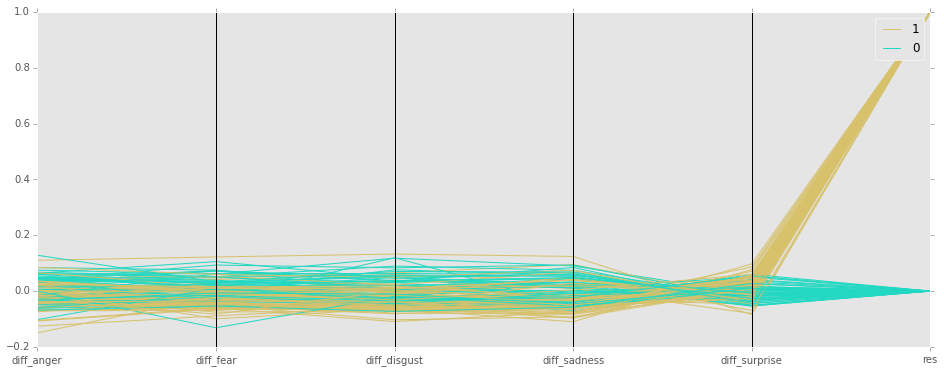

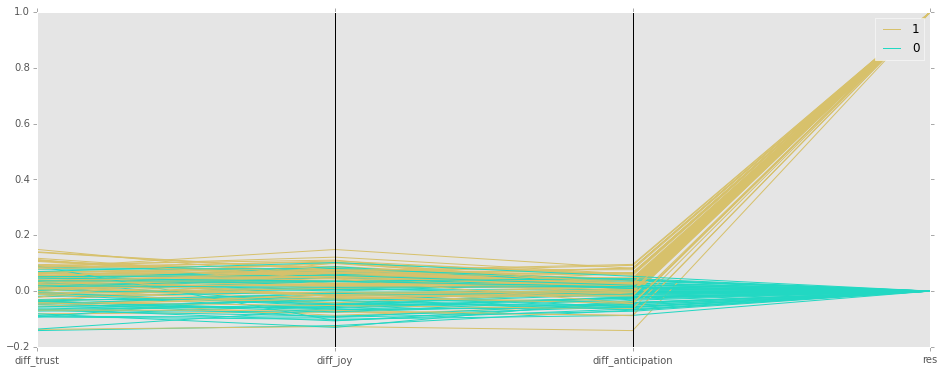

In [99]:
from pandas.tools.plotting import parallel_coordinates

df = CreateDfForModel(ft_wld=False)

df['res'] = df.result
# df['res'] = [0.1 if res==1 else -0.1 for res in df.result]

data = df[[
        'pos_home',
        'neg_away',
        'diff_pos',
        'res'
          ] + ['result']]
# data = df[df.columns[2:]]

plt.figure(figsize=(16, 6))
parallel_coordinates(data, 'result')


# *************************************************
df['res'] = df.result
# df['res'] = [0.5 if res==1 else -0.5 for res in df.result]
data = df[[
        'diff_anger',
        'diff_fear',
        'diff_disgust',
        'diff_sadness',
        'diff_surprise',
        'res'
          ] + ['result']]
df['res'] = [0.1 if res==1 else -0.1 for res in df.result]
plt.figure(figsize=(16, 6))
parallel_coordinates(data, 'result')




# *************************************************
df['res'] = df.result
# df['res'] = [0.5 if res==1 else -0.5 for res in df.result]
data = df[[
        'diff_trust',
        'diff_joy',
        'diff_anticipation',
        'res'
          ] + ['result']]
df['res'] = [0.1 if res==1 else -0.1 for res in df.result]
plt.figure(figsize=(16, 6))
parallel_coordinates(data, 'result')

## Radviz

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


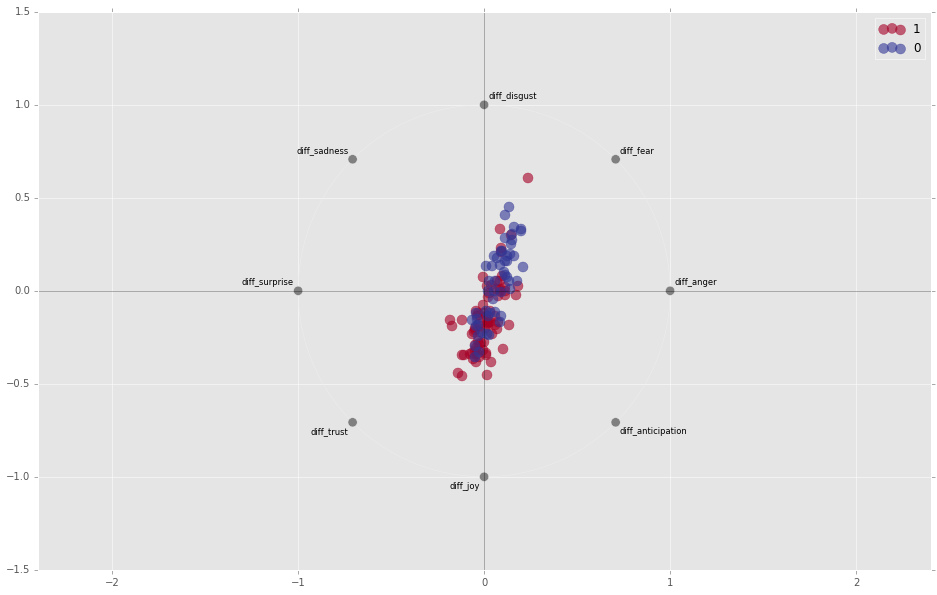

In [98]:
from pandas.tools.plotting import radviz


df = CreateDfForModel(ft_wld=False)

data = df[[
        'diff_anger',
        'diff_fear',
        'diff_disgust',
        'diff_sadness',
        'diff_surprise',
        'diff_trust',
        'diff_joy',
        'diff_anticipation',
          ] + ['result']]

# data = df[df.columns[2:]]

plt.figure(figsize=(16, 10))

radviz(data, 'result', alpha=0.6, s=100, colormap='RdYlBu')
plt.axhline(y=0, c="k", alpha=0.3)
plt.axvline(x=0, c="k", alpha=0.3)